In [39]:
import pandas as pd
import seaborn as sns

In [40]:
# Paths to datasets
consensus_path = '/app/intermediate/consensus_raw.csv'
individual_path = '/app/intermediate/individual_raw.csv'

# Load consensus dataset
consensus_df = pd.read_csv(consensus_path)

# Load individual dataset
individual_df = pd.read_csv(individual_path)

# Label Analysis

Individual dataset shape: (3901, 2)

Rating distribution:
rating
1.0     200
2.0     450
3.0     816
4.0    1122
5.0    1159
Name: count, dtype: int64


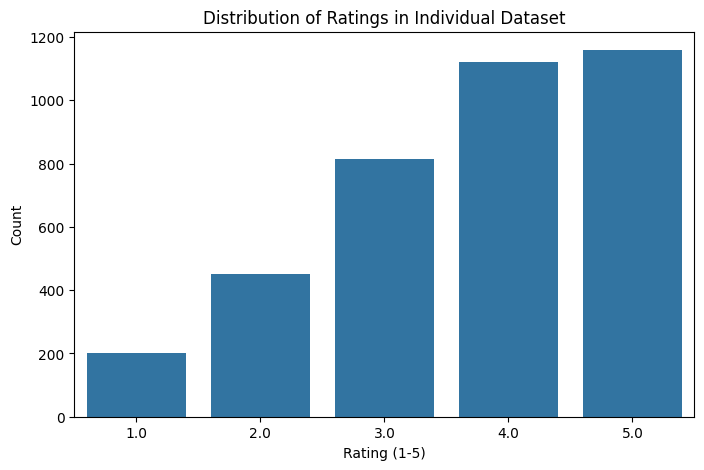

In [42]:
## Individual Dataset Analysis

print("Individual dataset shape:", individual_df.shape)
print("\nRating distribution:")
print(individual_df['rating'].value_counts().sort_index())

import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(data=individual_df, x='rating')
plt.title('Distribution of Ratings in Individual Dataset')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.show()

In [36]:
## Consensus Dataset Analysis

print("Consensus dataset shape:", consensus_df.shape)

# Compute consensus rating (most frequent rating)
rating_cols = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
consensus_df['consensus_rating'] = consensus_df[rating_cols].idxmax(axis=1).str.split('_').str[1].astype(int)

print("\nConsensus rating distribution (majority vote):")
print(consensus_df['consensus_rating'].value_counts().sort_index())

# Compute average rating
consensus_df['avg_rating'] = (1*consensus_df['rating_1'] + 2*consensus_df['rating_2'] + 3*consensus_df['rating_3'] + 4*consensus_df['rating_4'] + 5*consensus_df['rating_5']) / consensus_df[rating_cols].sum(axis=1)

print("\nAverage rating statistics:")
print(consensus_df['avg_rating'].describe())

Consensus dataset shape: (609, 6)

Consensus rating distribution (majority vote):
consensus_rating
1     53
2     81
3    132
4    198
5    145
Name: count, dtype: int64

Average rating statistics:
count    595.000000
mean       3.529108
std        1.115542
min        1.000000
25%        3.000000
50%        4.000000
75%        4.183333
max        5.000000
Name: avg_rating, dtype: float64


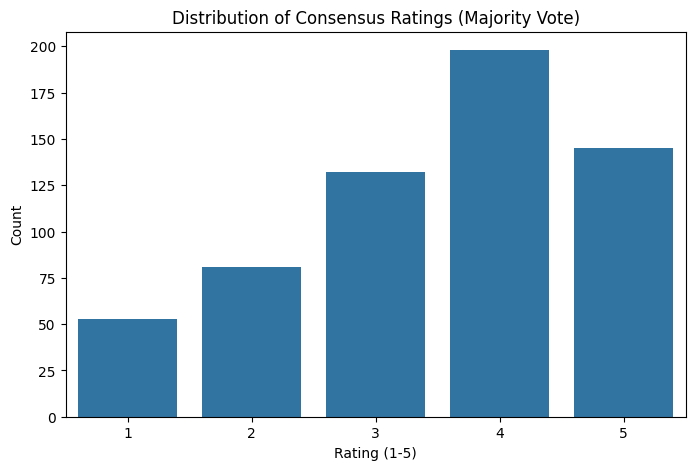

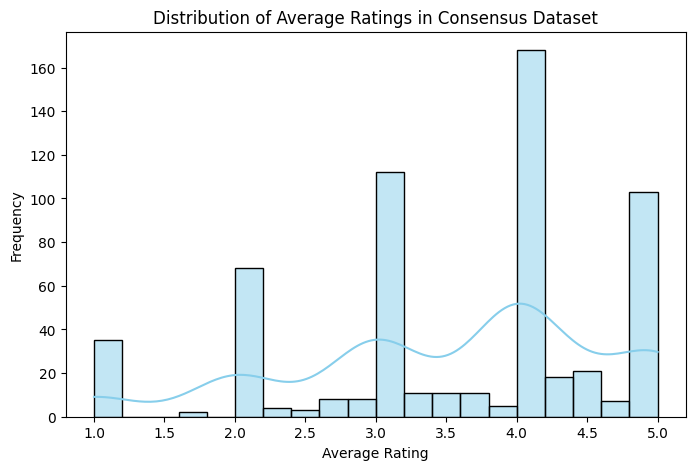

In [38]:
plt.figure(figsize=(8,5))
sns.countplot(data=consensus_df, x='consensus_rating')
plt.title('Distribution of Consensus Ratings (Majority Vote)')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(consensus_df['avg_rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings in Consensus Dataset')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

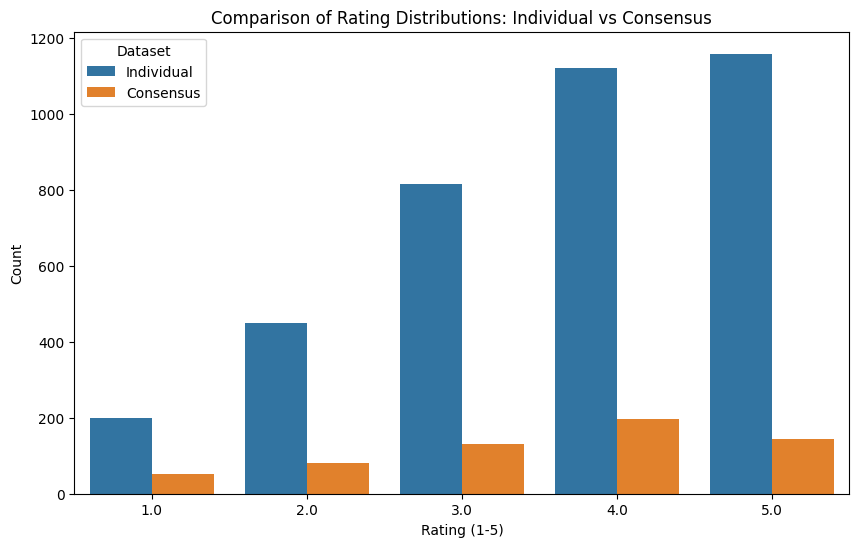

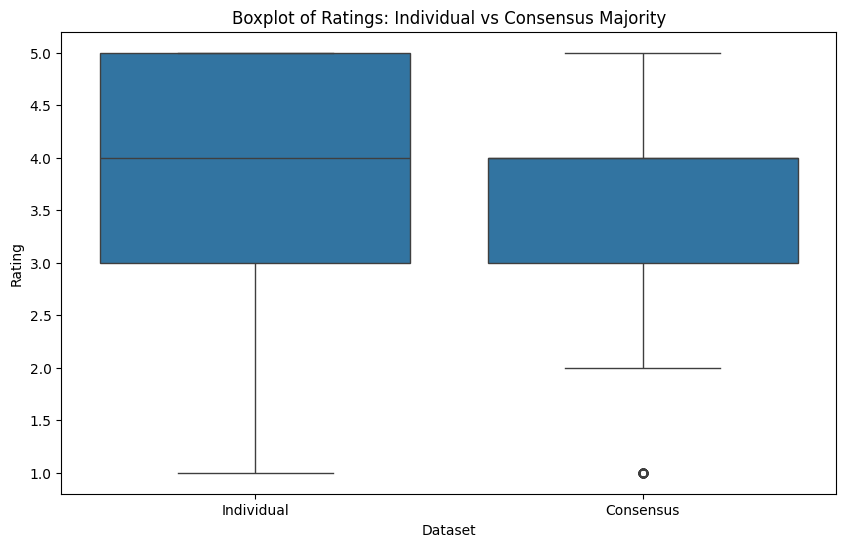

In [28]:
## Comparison of Distributions

# Combine for comparison
individual_df['dataset'] = 'Individual'
consensus_df['dataset'] = 'Consensus'

# For comparison, use consensus_rating for consensus
comparison_df = pd.concat([
    individual_df[['rating', 'dataset']].rename(columns={'rating': 'label'}),
    consensus_df[['consensus_rating', 'dataset']].rename(columns={'consensus_rating': 'label'})
], ignore_index=True)

plt.figure(figsize=(10,6))
sns.countplot(data=comparison_df, x='label', hue='dataset')
plt.title('Comparison of Rating Distributions: Individual vs Consensus')
plt.xlabel('Rating (1-5)')
plt.ylabel('Count')
plt.legend(title='Dataset')
plt.show()

# Also compare individual vs consensus majority rating
comparison_avg_df = pd.concat([
    individual_df[['rating', 'dataset']].rename(columns={'rating': 'label'}),
    consensus_df[['consensus_rating', 'dataset']].rename(columns={'consensus_rating': 'label'})
], ignore_index=True)

plt.figure(figsize=(10,6))
sns.boxplot(data=comparison_avg_df, x='dataset', y='label')
plt.title('Boxplot of Ratings: Individual vs Consensus Majority')
plt.xlabel('Dataset')
plt.ylabel('Rating')
plt.show()

Number of annotators per paragraph:
num_annotators
0      14
1     454
5       1
6       2
8       3
9       2
11     12
12     26
13      5
14      5
15     19
16     12
17      6
18     14
19     13
20     20
21      1
Name: count, dtype: int64

MAE statistics:
count    609.000000
mean       0.143283
std        0.280461
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.230769
Name: mae, dtype: float64


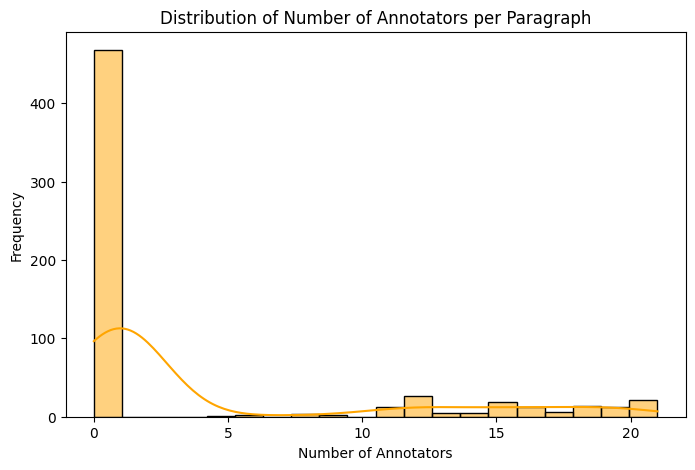

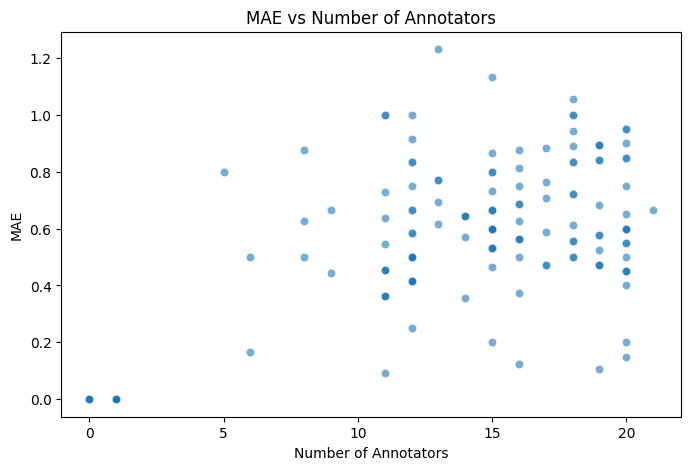

In [30]:
## Agreement Analysis in Consensus Dataset

# Number of annotators per paragraph
consensus_df['num_annotators'] = consensus_df[rating_cols].sum(axis=1)

print("Number of annotators per paragraph:")
print(consensus_df['num_annotators'].value_counts().sort_index())

# MAE from consensus rating (as proxy for disagreement)
consensus_df['mae'] = 0.0
for idx, row in consensus_df.iterrows():
    c = row['consensus_rating']
    total = row[rating_cols].sum()
    if total > 0:
        mae = sum(abs(i - c) * row[f'rating_{i}'] for i in range(1,6)) / total
        consensus_df.at[idx, 'mae'] = mae

print("\nMAE statistics:")
print(consensus_df['mae'].describe())

plt.figure(figsize=(8,5))
sns.histplot(consensus_df['num_annotators'], bins=20, kde=True, color='orange')
plt.title('Distribution of Number of Annotators per Paragraph')
plt.xlabel('Number of Annotators')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=consensus_df, x='num_annotators', y='mae', alpha=0.6)
plt.title('MAE vs Number of Annotators')
plt.xlabel('Number of Annotators')
plt.ylabel('MAE')
plt.show()

Confusion Matrix (rows: true/majority, columns: predicted/individual):
[[ 62  20  11   3   1]
 [ 28 177  82  54   5]
 [ 17  64 292  93  26]
 [  5  56 148 500 164]
 [ 11  16  58 160 538]]

Overall Accuracy: 0.606


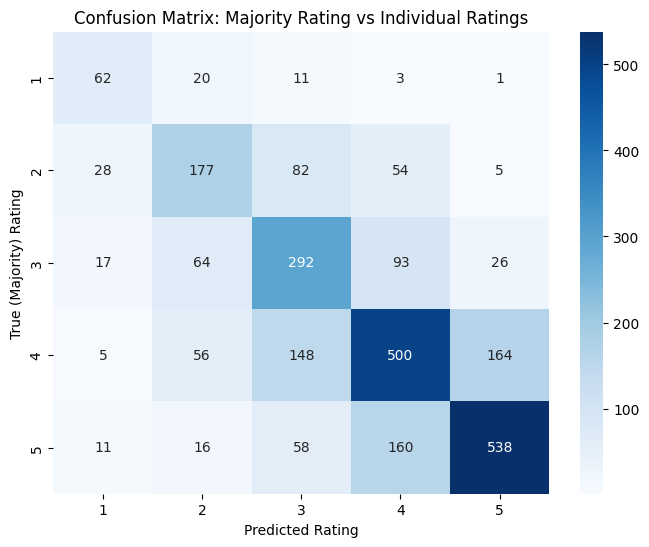

In [31]:
## Confusion Matrix: Majority Rating vs Individual Ratings

# Expand the consensus data to individual ratings
expanded_data = []
for idx, row in consensus_df.iterrows():
    c = row['consensus_rating']
    for i in range(1, 6):
        count = int(row[f'rating_{i}'])
        for _ in range(count):
            expanded_data.append({'true': c, 'predicted': i})

expanded_df = pd.DataFrame(expanded_data)

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(expanded_df['true'], expanded_df['predicted'])
accuracy = accuracy_score(expanded_df['true'], expanded_df['predicted'])

print("Confusion Matrix (rows: true/majority, columns: predicted/individual):")
print(cm)
print(f"\nOverall Accuracy: {accuracy:.3f}")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix: Majority Rating vs Individual Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('True (Majority) Rating')
plt.show()

We can see the bias towards higher ratings in the distributions of each majority classes.